In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from visual_behavior.data_access import loading as loading

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [4]:
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

### load experiments_table from cache

In [5]:
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
print(cache_dir)


//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache


In [6]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


### limit to containers with all 3 experience levels

In [7]:
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

In [8]:
print(len(experiments_table))

955


#### add useful columns

In [9]:
# experiments_table = utilities.add_cell_type_column(experiments_table)
# experiments_table = utilities.add_experience_exposure_column(experiments_table)
# experiments_table = utilities.add_binned_depth_column(experiments_table)

### get useful info

In [10]:
experience_level = np.sort(experiments_table.experience_level.unique())
print(experience_level)

['Familiar' 'Novel 1' 'Novel >1']


In [11]:
exposures = np.sort(experiments_table.experience_exposure.unique())
print(exposures)

['Familiar 0' 'Familiar 1' 'Familiar 2' 'Familiar 3' 'Familiar > 3'
 'Novel 0' 'Novel 1' 'Novel 2' 'Novel 3' 'Novel > 3']


In [12]:
cell_types = np.sort(experiments_table.cell_type.unique() )
print(cell_types)

['Excitatory' 'Sst Inhibitory' 'Vip Inhibitory']


### get some experiment

In [13]:
# experiment_id = experiments_table.index.values[0]
# dataset = cache.get_behavior_ophys_experiment(experiment_id)

### get multi_session_df

In [14]:
%%time

# set various params
df_name = 'trials_run_speed_df'
conditions = ['ophys_experiment_id', 'stimulus_change']
use_events = False
filter_events = False

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

# keep changes only
multi_session_df = multi_session_df[multi_session_df.stimulus_change==True]

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))

# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()


1941
955
955
Wall time: 2.93 s


In [15]:
# multi_session_df = original_multi_session_df.copy()

In [16]:
# drop duplicates for sessions
multi_session_df = multi_session_df.drop_duplicates(subset=['ophys_session_id'])

In [17]:
# remove weird 7th epoch
# multi_session_df = multi_session_df[multi_session_df.epoch!=6]

In [18]:
# def merge_experience_epoch(row):
#     return row.experience_level+' epoch '+str(int(row.epoch))

# multi_session_df['experience_epoch'] = multi_session_df[['experience_level', 'epoch']].apply(axis=1, func=merge_experience_epoch)

# experience_epoch = np.sort(multi_session_df.experience_epoch.unique())

In [19]:
multi_session_df.keys()

Index(['ophys_experiment_id', 'stimulus_change', 'mean_response',
       'sem_response', 'mean_trace', 'sem_trace', 'trace_timestamps',
       'mean_responses', 'mean_baseline', 'sem_baseline', 'peak_response',
       'time_to_peak', 'fano_factor',
       'fraction_significant_p_value_gray_screen',
       'fraction_significant_p_value_omission',
       'fraction_significant_p_value_stimulus', 'reliability',
       'equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'file_id', 'cell_type', 'depth', 'binned_depth',
       'area_depth', 'area_binned_dept

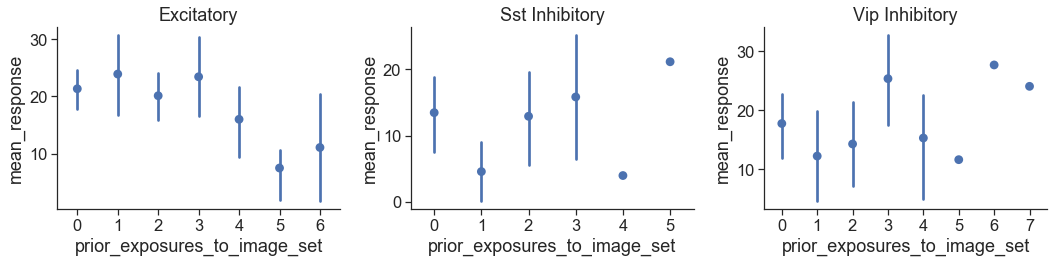

In [20]:
df = multi_session_df.copy()
df = df[df.passive==False]
df['prior_exposures_to_image_set'] = [int(x) for x in df.prior_exposures_to_image_set.values]

fig, ax = plt.subplots(1,3, figsize=(15,4))
for i, cell_type in enumerate(cell_types):
    ax[i] = sns.pointplot(data=df[(df.cell_type==cell_type)&(df.experience_level!='Familiar')],
                  x='prior_exposures_to_image_set', y='mean_response', 
                       join=False, dodge=0.5, ax=ax[i])
    ax[i].set_title(cell_type)
#     ax[i].legend(title='', fontsize='small', bbox_to_anchor=(1,1))
fig.tight_layout()

### limit to containers with all exp levels, most recent familiar and second novel active

In [21]:
multi_session_df = utilities.limit_to_last_familiar_second_novel_active(multi_session_df)
multi_session_df = utilities.limit_to_containers_with_all_experience_levels(multi_session_df)

### look at averages

In [22]:
import visual_behavior.visualization.utils as utils

(0, 27.18980570952592)

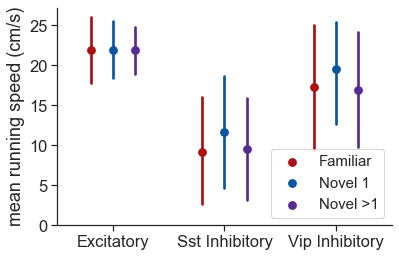

In [23]:
palette = utils.get_experience_level_colors()
experience_levels = np.sort(multi_session_df.experience_level.unique())

fig, ax = plt.subplots()
ax = sns.pointplot(data=multi_session_df, x='cell_type', y='mean_response', hue='experience_level', 
             hue_order=experience_levels, palette=palette, join=False, dodge=0.4, ax=ax)
ax.legend(loc='lower right', fontsize='small', title='')
ax.set_xlabel('')
ax.set_ylabel('mean running speed (cm/s)')
ax.set_ylim(ymin=0)